# Convolutional Neural Networks in Searching for EBs in TESS
-Te Han

In this project, we use Convolutional Neural Networks (CNN) to search for eclipsing binaries in TESS data. The primary methods are based on the two papers and one program from Kyle A. Pearson.

[1] Kyle A. Pearson, Leon Palafox, and Caitlin A. Griffith. "Searching for Exoplanets using Artificial Intelligence." 2018, MNRAS, 474, 478

[2] Kyle A. Pearson. "A search for multi-planet systems with TESS using a Bayesian N-body retrieval and machine learning."

[3] Github for both projects above. https://github.com/pearsonkyle/Exoplanet-Artificial-Intelligence

The author compares multiple deep learning logrithms as well as basic least-square box fitting in searching for exoplanets based on the light curve and concludes that CNN performs relatively good. Using Exoplanet Light Curve Analysis (ELCA), the author trains the CNN with transit with various sizes and contradicts with non-transits light curves. Based on the CNN network architecture the author build, I use batman package to produce EB light curves. With various training parameters, CNN has performed well in searching for EB in TESS data.

# Section 1: CNN architecture

This part copies Pearson's code for the CNN architecture.

In [1]:
import os
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, Concatenate, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

#from ELCA import lc_fitter, transit

def pn_rates(model,X,y):
    y_pred = np.round( model.predict(X) )

    pos_idx = y==1
    neg_idx = y==0

    tp = np.sum(y_pred[pos_idx]==1)/y_pred.shape[0]
    fn = np.sum(y_pred[pos_idx]==0)/y_pred.shape[0]

    tn = np.sum(y_pred[neg_idx]==0)/y_pred.shape[0]
    fp = np.sum(y_pred[neg_idx]==1)/y_pred.shape[0]

    return fn,fp

def make_cnn(maxlen):
    
    input_local = Input(shape=(maxlen,1))
    x = Conv1D(16, 5, strides=1)(input_local)
    #x = Conv1D(16, 5, strides=1)(x)
    x = AveragePooling1D(pool_size=5, strides=2)(x)
    x = Conv1D(8, 5, strides=1)(x)
    #x = Conv1D(8, 5, strides=1)(x)
    x = AveragePooling1D(pool_size=5, strides=2)(x)
    
    xf = Flatten()(x)
    z = Dense(64, activation='relu')(xf)
    #z = Dropout(0.1)(z)
    z = Dense(32, activation='relu')(z)
    z = Dense(8, activation='relu')(z)

    output = Dense(1, activation='sigmoid', name='main_output')(z)
    model = Model(inputs=input_local, outputs=output)
    
    SGDsolver = SGD(lr=0.1, momentum=0.25, decay=0.0001, nesterov=True)
    model.compile(loss='binary_crossentropy',
                optimizer=SGDsolver,
                metrics=['accuracy'])
    return model

/home/tehan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tehan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tehan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tehan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

# Section 2: Training CNN


#### Batman requires 9 parameters:
1. orbital period
2. time of inferior conjunction
3. Time of secondary eclipse center.
4. planet radius (in units of stellar radii)
5. Planet-to-star flux ratio (for secondary eclipse models).
6. semi-major axis (in units of stellar radii)
7. orbital inclination (in degrees)
8. eccentricity
9. longitude of periastron (in degrees)

#### If we start with main sequence stars and circular orbits, we only have 5 parameters to randomize. 
1. r1
2. r2
3. a semimajor
4. t0 time of inferior conjunction
5. inc

#### with these we can get
1. Planet-to-star flux ratio (for secondary eclipse models)
2. orbital period
3. Time of secondary eclipse center.

#### and fixed values
1. ecc = 0
2. longitude of periastron (in degrees) = 90

In [2]:
import batman
from astropy.io import ascii
from astropy.io import fits
import matplotlib.patches as mpatches
from astropy import constants as const

main_seq = ascii.read(r'/mnt/d/Astro/mass_r_teff.dat')
mass = main_seq['M/Msun']
radius = main_seq['log10(r/cm)']
Teff = main_seq['log10(Teff/K)']

def EB(number_of_samples,n_period):            
    positive = []
    for i in range(number_of_samples):
        #fixed
        params = batman.TransitParams()       #object to store transit parameters        
        params.ecc = 0.                       #eccentricity
        params.w = 90.                        #longitude of periastron (in degrees)
        params.limb_dark = 'quadratic'        #limb darkening model
        params.u = [0.1, 0.3]                 #limb darkening coefficients [u1, u2]
        
        #randomize
        n1 = np.random.randint(1, high = len(mass))
        n2 = np.random.randint(n1)
        r1 = 10 ** radius[n1]
        r2 = 10 ** radius[n2] 
        T1 = 10 ** Teff[n1]
        T2 = 10 ** Teff[n2] 
        m1 = mass[n1]
        m2 = mass[n2] 
        params.a = np.random.rand() * 10 + 1       #semi-major axis (in units of stellar radii)
        params.inc = 90. + np.random.randn() * 10  #orbital inclination (in degrees)
        
        # calculated based on previous parameters
        params.fp = (r2 ** 2 * T2 ** 4) / (r1 ** 2 * T1 ** 4)            #Planet-to-star flux ratio (for secondary eclipse models).
        params.per = (4 * np.pi **2 * (params.a * r1 * 1e-2) ** 3 
                      /(const.G.value * const.M_sun.value * (m1 + m2))) ** 0.5 / (24*3600)      #orbital period
        params.rp = r2 / r1                                              #planet radius (in units of stellar radii)
        params.t0 = 0.5 * params.per * n_period                          #time of inferior conjunction
        params.t_secondary = params.t0 - params.per/2                    #Time of secondary eclipse center. 
        
        #sampled time 
        t = np.linspace(0, n_period*params.per, 200)
        
        #initializes model
        m = batman.TransitModel(params, t, transittype = 'primary')     
        flux_1 = m.light_curve(params)
        m = batman.TransitModel(params, t, transittype = 'secondary') 
        flux_2 = m.light_curve(params)
    
        #eliminate flat light curves due to high inclination
        flux = (flux_1 + flux_2) 
        if (np.max(flux) == np.min(flux)):
            params.inc = 90.
            m = batman.TransitModel(params, t, transittype = 'primary') 
            flux_1 = m.light_curve(params)
            m = batman.TransitModel(params, t, transittype = 'secondary')  
            flux_2 = m.light_curve(params)
            flux = (flux_1 + flux_2)
            flux /= (np.max(flux) - np.min(flux)) / 4     #4 is just a normalization factor that is used on all lc
            flux -= np.average(flux)+ 0.1 * np.random.randn(len(flux_1))
        else:
            flux /= (np.max(flux) - np.min(flux)) / 4
            flux -= np.average(flux)+ 0.1 * np.random.randn(len(flux_1))
        positive.append(flux)
    return positive

def non_EB(number_of_samples):            
    negative = []
    for i in range(number_of_samples):
        #fixed
        params = batman.TransitParams()       #object to store transit parameters
        params.ecc = 0.                       #eccentricity
        params.w = 90.                        #longitude of periastron (in degrees)
        params.limb_dark = 'quadratic'        #limb darkening model
        params.u = [0.1, 0.3]                 #limb darkening coefficients [u1, u2, u3, u4]
        
        #randomize
        n1 = np.random.randint(1, high = len(mass))
        n2 = np.random.randint(n1)
        r1 = 10 ** radius[n1]
        r2 = 10 ** radius[n2] 
        T1 = 10 ** Teff[n1]
        m1 = mass[n1]
        m2 = mass[n2] 
        params.a = np.random.rand() * 10 + 1       #semi-major axis (in units of stellar radii)
        params.inc = 90. + np.random.randn() * 25  #orbital inclination (in degrees)        
        
        # calculated based on previous parameters
        params.per = (4 * np.pi **2 * (params.a * r1 * 1e-2) ** 3 
                      /(const.G.value * const.M_sun.value * (m1 + m2))) ** 0.5 / (24*3600)      #orbital period
        params.rp = r2 / r1                        #planet radius (in units of stellar radii)
        params.t0 = 0.5 * params.per               #time of inferior conjunction
        
        #sampled time 
        t = np.linspace(0, params.per, 200)
        
        #initializes model
        m = batman.TransitModel(params, t, transittype = 'primary')    
        flux_1 = m.light_curve(params)
    
        #add noise to flux
        if (np.max(flux_1) == np.min(flux_1)):
            flux = 1 * np.random.randn(len(flux_1))
        else:
            flux = flux_1
            flux /= (np.max(flux_1) - np.min(flux_1)) / 4
            flux -= np.average(flux)+ 0.1 * np.random.randn(len(flux_1))
        negative.append(flux)
    return negative

In [3]:
positive = EB(100000,1)
negative1 = non_EB(30000)
negative2 = EB(10000,1.3)
negative3 = EB(10000,1.6)
negative4 = EB(10000,2)
negative5 = EB(10000,3)
negative6 = EB(10000,4)
negative7 = EB(10000,5)
negative8 = EB(10000,6)

X = np.vstack([positive, negative1,negative2,negative3, negative4,negative5,negative6,negative7, negative8])
X = X.reshape((X.shape[0], X.shape[1], 1))
y = np.hstack([np.ones(len(positive)), np.zeros(len(positive))])

Text(-100, -1, 'Negative')

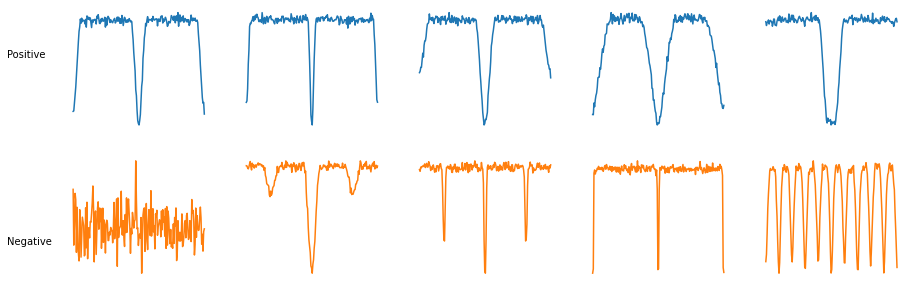

In [4]:
fig, axs = plt.subplots(2,5, figsize=(15, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j in range(5):
    axs[j].plot(X[j,:,0])
    axs[j].axis('off')

axs[5].plot(X[110000,:,0],'C1')
axs[5].axis('off')
axs[6].plot(X[141004,:,0],'C1')
axs[6].axis('off')
axs[7].plot(X[149998,:,0],'C1')
axs[7].axis('off')
axs[8].plot(X[158001,:,0],'C1')
axs[8].axis('off')
axs[9].plot(X[181000,:,0],'C1')
axs[9].axis('off')

axs[0].text(-100,-1,'Positive')
axs[5].text(-100,-1,'Negative')

We generate 10000 positive samples and 10000 negative samples. The first row shows 5 positive examples, and the second row shows two planetary transit, a noise, and two multiple periods samples. Adding more negative samples that have similar shapes with the positive ones improves the accuracy of the CNN when it predict a new light curve. 

In [5]:
nb_epoch = 20
batch_size = 100
cnn = make_cnn(200)
history = cnn.fit(X, y, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_split=0.0, validation_data=None)

cnn.save_weights('tess_cnn.h5')

score = cnn.evaluate(X, y, verbose=1)
fn,fp = pn_rates(cnn,X,y)
print('\nTrain loss:', score[0])
print('Train accuracy:', score[1])
print('Train FP:',fp)
print('Train FN:',fn)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
200000/200000 [==============================] - 12s 59us/sample - loss: 0.2844 - acc: 0.8701
Epoch 2/20
200000/200000 [==============================] - 10s 51us/sample - loss: 0.2104 - acc: 0.9026
Epoch 3/20
200000/200000 [==============================] - 9s 47us/sample - loss: 0.1652 - acc: 0.9229
Epoch 4/20
200000/200000 [==============================] - 9s 47us/sample - loss: 0.1416 - acc: 0.9345
Epoch 5/20
200000/200000 [==============================] - 10s 50us/sample - loss: 0.1268 - acc: 0.9418
Epoch 6/20
200000/200000 [==============================] - 11s 53us/sample - loss: 0.1163 - acc: 0.9470
Epoch 7/20
200000/200000 [==============================] - 10s 48us/sample - loss: 0.1065 - acc: 0.9509
Epoch 8/20
200000/200000 [=============================

# Section 3: Testing CNN

We first examine its accuracy on never seen peudo light curves.

Using these samples, the CNN have a training resut of

Train loss: 0.12059255138733478

Train accuracy: 0.9457

Train FP: 0.03165

Train FN: 0.02265

This is using 20000 samples and 50 epoches. 

### Discussion: 
Here we have several choice of training the model: sample number, epoch, batch_size, and number of points on the light curves. Increasing sample number makes the training slower, but also improves accuracy. Increasing epoch has similar results. I'm still not very certain about the batch_size, and I know it influence the rate of convergence of accuracy in succeeding epoch. 

Lastly, the number of points on the light curves is very important. We have about 1000 points on the TESS light curves in general. The number should not exceed that. Also, too few points makes CNN harded to recognize a feature, and two many points make the training and prediction slower. I trained models with 100,200,300, and 500 points. In comparison, 100 model have poor accuracy, and 300 and 500 model do not have clear advantage to 200. So, we choose to present 200 points model here. 

In [6]:
# test the network 

positive = EB(10000,1)
negative1 = non_EB(5000)
negative2 = EB(3000,2)
negative3 = EB(2000,3)
Xt = np.vstack([positive,negative1,negative2,negative3])
Xt = Xt.reshape((Xt.shape[0], Xt.shape[1], 1))
yt = np.hstack([np.ones(len(positive)), np.zeros(len(positive))])

score = cnn.evaluate(Xt, yt, verbose=1)
fn,fp = pn_rates(cnn,Xt,yt)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])
print('Test FP:',fp)
print('Test FN:',fn)

20000/20000 [==============================] - 1s 41us/sample - loss: 0.0910 - acc: 0.9578

Test loss: 0.09100170778742518
Test accuracy: 0.95785
Test FP: 0.0237
Test FN: 0.01845


Text(-100, 0, 'Negative')

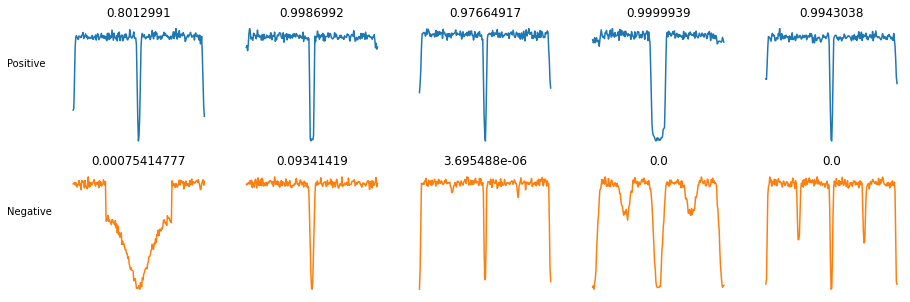

In [7]:
y_pos = cnn.predict(Xt[:10000])
y_neg = cnn.predict(Xt[10000:])

fig, axs = plt.subplots(2,5, figsize=(15, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j in range(5):
    axs[j].plot(Xt[j+10,:,0])
    axs[j].set_title(y_pos[j+10,0])
    axs[j].axis('off')
for j in range(5):
    axs[j+5].plot(Xt[j+14998,:,0],'C1')
    axs[j+5].set_title(y_neg[j+4998,0])
    axs[j+5].axis('off')
axs[0].text(-100,-1,'Positive')
axs[5].text(-100,0,'Negative')

Some of the testing light curves and their test results. 1 means CNN thinks it is likely to be an EB light curve, and 0 means CNN thinks it is unlikely to be one. The blue light curves are generated with EB model and the orange ones are generated as other models. 

For the blue (positive model) lc's, we can see that CNN performs good on those with deep secondary eclipse and is suspicious on the shallower ones. This is understandable because those lc's look more like planetary transits, which are given to CNN as negative training samples. 

For the orange (negative model) lc's, CNN is very certain about these 5 examples as non-EBs. 

Now, we "teached" CNN to recognize light curves with primary eclipse (time of mid-eclipse) at the center, secondary eclipse presented, and single-phased light curves. We should test our model on real TESS data, which may have much more uncertainties and unexpected light curves. 

The test accuracy is 

Test loss: 0.12775814597473872

Test accuracy: 0.9429

Test FP: 0.0344

Test FN: 0.0227

which is a little below the training accuracy. Now let's look at some examples.

# Section 4: CNN on TESS

In [23]:
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
from scipy.interpolate import interp1d

target_name = 'M71'
size = 15 # pixel size
radSearch = 15 * 21 * 0.707 / 3600  #radius in degrees 

In [29]:
catalogData = Catalogs.query_object(target_name, radius = radSearch, catalog = "TIC")
# print(catalogData['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'])

# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 14

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )

#show sectors 
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']
coord = SkyCoord(ra, dec, unit = "deg")
sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

#get FFI cutout
hdulist = Tesscut.get_cutouts(coord, size)
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]
wcs = WCS(hdu1[2].header)

def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0014-1-3     14      1   3


In [30]:
aperture = hdu1[2].data == 1
flux1 = make_lc(hdu1[1].data['FLUX'], aperture)
time1 = hdu1[1].data['TIME']

bkgAperture = hdu1[1].data['FLUX'][0] < np.percentile(hdu1[1].data['FLUX'][0], 5)
bkgFlux1 = make_lc(hdu1[1].data['FLUX'], bkgAperture)

data_time = hdu1[1].data['TIME']
data_flux = hdu1[1].data['FLUX']
data_flux.reshape(np.shape(data_time)[0], size ** 2)
flux_2d = data_flux.reshape(np.shape(data_time)[0],size ** 2)
#minus median
yy, background, xx= np.meshgrid(data_flux[0,:,0], bkgFlux1, data_flux[0,0,:])
bkgSubFlux = data_flux - background / np.sum(bkgAperture)

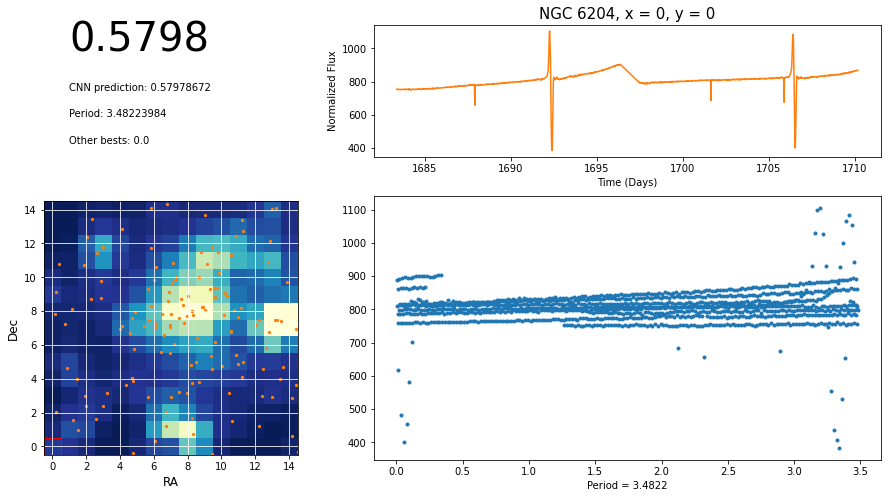

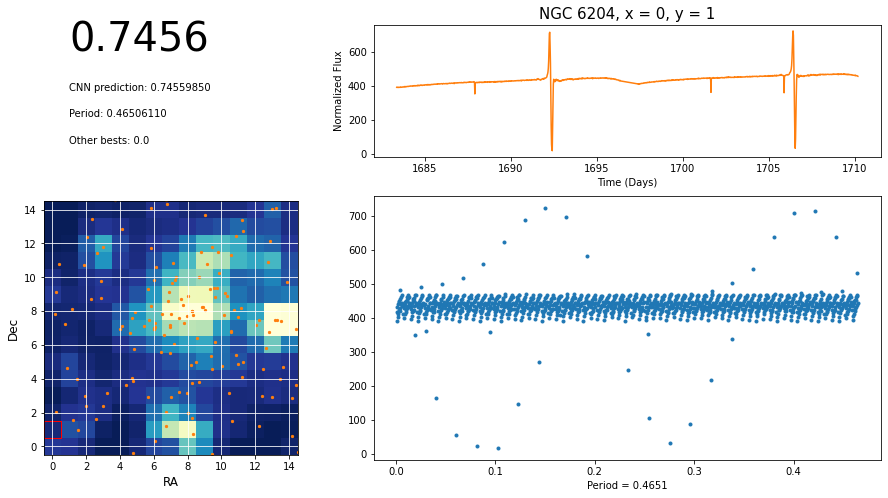

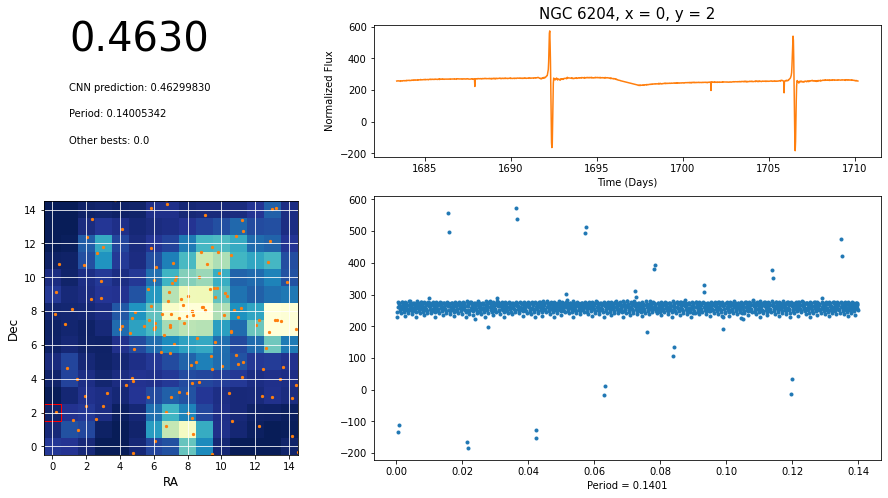

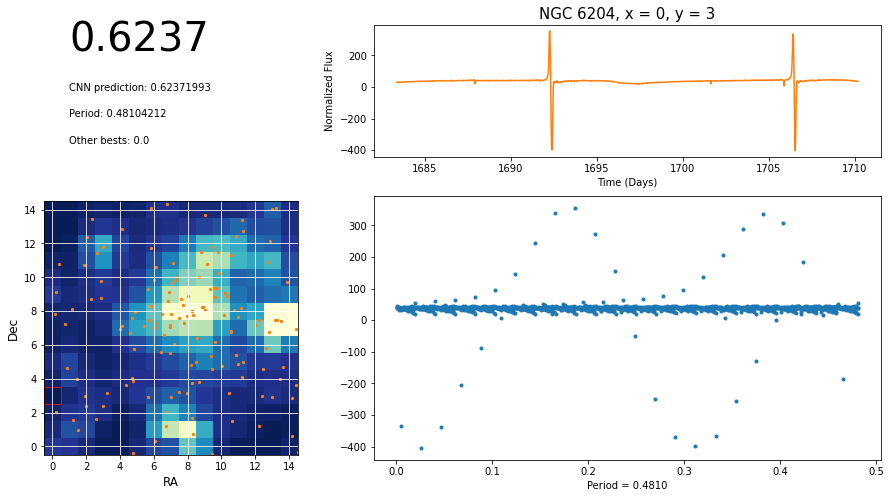

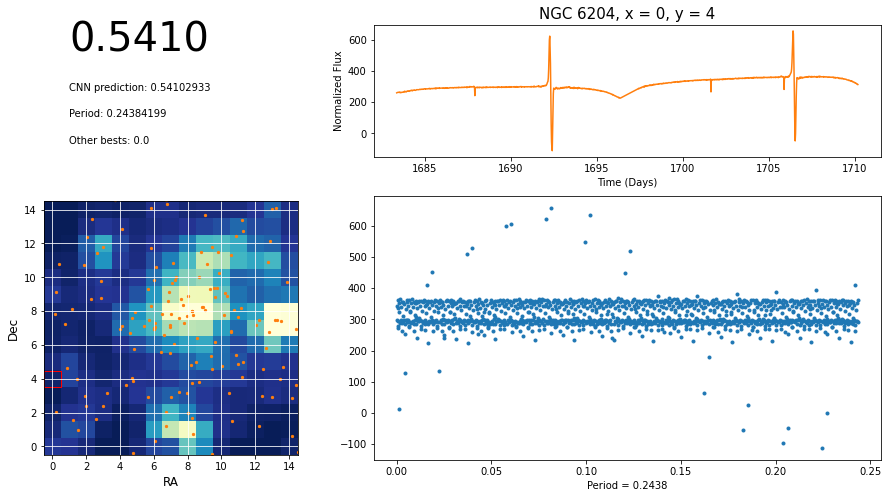

In [ ]:
for l in range(np.shape(data_flux)[2]):
    for i in range(np.shape(data_flux)[1]):
#        try:
            flux_1d = bkgSubFlux[:,i,l]
#             flux_cut = np.concatenate((flux_1d[a:b], flux_1d[c:d]), axis=None)
            fig, axs = plt.subplots(2,2, figsize=(15, 8), facecolor='w', edgecolor='k', subplot_kw={'projection': None}, gridspec_kw={'width_ratios': [1,2],'height_ratios': [1,2], 'wspace': 0.2})
            axs = axs.ravel()
            
            axs[0].axis('off')
            axs[2].imshow(firstImage, origin = 'lower', cmap = plt.cm.YlGnBu_r, vmax = np.percentile(firstImage, 98), vmin = np.percentile(firstImage, 5))
            axs[2].grid(axis = 'both',color = 'white', ls = 'solid')
            nearbyLoc = wcs.all_world2pix(nearbyStars[0:],0)
            axs[2].scatter(nearbyLoc[0:, 0], nearbyLoc[0:, 1], s = 5, color = 'C1')
            axs[2].set_xlim(-0.5,size - 0.5)
            axs[2].set_ylim(-0.5,size - 0.5)
            axs[2].set_xlabel('RA', fontsize = 12)
            axs[2].set_ylabel('Dec', fontsize = 12)
            axs[2].scatter(l,i, marker = 's', s = 270, facecolors='none', edgecolors='r')
            axs[1].plot(data_time, flux_1d, color = 'C1')
            #axs[1].plot(data_time, flux_1d, marker = '.', ls = '', ms = 4, c = 'C0')
            axs[1].set_title('NGC 6204, ' + 'x = ' + str(l ) + ', y = ' + str(i ), fontsize = 15)
            axs[1].set_ylabel('Normalized Flux')
            axs[1].set_xlabel('Time (Days)')
            ######
            a_0 = 0.1
            r = 1.04
            length = 100
            geometric = [a_0 * r ** (n - 1) for n in range(1, length + 1)]
            period = np.array(geometric)
            t_0 = np.linspace(0,1,20)
            predict = np.zeros((len(period),len(t_0)))
            
            for j in range(len(period)):
                p = period[j]
                for k in range(len(t_0)):
                    t_pf = np.array((data_time + t_0[k] * p) % p )
                    t = np.linspace(np.min(t_pf), np.max(t_pf), 200)
                    f = interp1d(t_pf, flux_1d, kind='nearest')
                    flux = f(t)
                    flux /= (np.max(flux) - np.min(flux)) / 4
                    flux -= np.average(flux)
                    predict[j][k] = cnn.predict(flux.reshape((1, 200, 1)))
            idx = np.where(predict == np.max(predict))
            ####
            period_ = np.linspace(period[idx[0][0]] / r ,period[idx[0][0]] * r,100)
            t_0 = np.linspace(0,1,20)
            predict = np.zeros((len(period_),len(t_0)))
    
            for j in range(len(period_)):
                p = period_[j]
                for k in range(len(t_0)):
                    t_pf = np.array((data_time + t_0[k] * p) % p )
                    t = np.linspace(np.min(t_pf), np.max(t_pf), 200)
                    f = interp1d(t_pf, flux_1d, kind='nearest')
                    flux = f(t)
                    flux /= (np.max(flux) - np.min(flux)) / 4
                    flux -= np.average(flux)
                    predict[j][k] = cnn.predict(flux.reshape((1, 200, 1)))
                
            idx = np.where(predict == np.max(predict))
            p = period_[idx[0][0]]

            t_pf = np.array((data_time + t_0[idx[1][0]] * p)%p)
            axs[3].plot(t_pf,flux_1d,'.')
            axs[3].set_xlabel('Period = %.4f' % period_[idx[0][0]])
            axs[0].text(0.1,0.8,'%.4f' % np.max(predict), fontsize=40)
            axs[0].text(0.1,0.5,'CNN prediction: %.8f' % np.max(predict), fontsize=10)
            axs[0].text(0.1,0.3,'Period: %.8f' % period_[idx[0][0]], fontsize=10)
            axs[0].text(0.1,0.1,'Other bests: ' + str(0.5 * len(idx) - 1), fontsize=10)
            #print('CNN prediction: ', np.max(predict))
            #print('Period :', period_[idx[0][0]])
            #print('Other bests :', 0.5 * len(idx) - 1)
            ######
            plt.show()
#        except:
#            print('error:' + 'x = ' + str(l + 1) + ', y = ' + str(i + 1))
#            pass